# Induktive Erwärmung Aufgabe 2

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
from netgen.csg import *
import numpy as np
import matplotlib.pyplot as plt

## Konstanten

In [2]:
lam_air = 0.0262
lam = CoefficientFunction([lam_air, 400, 400])

## Mesh und Qe-Gridfunction importieren

In [3]:
mesh = Mesh("my_mesh.vol")  # Load mesh
Qespace = L2(mesh, order=4)
Qe = GridFunction(Qespace)
Qe.Load("qe_gf.gf")  # Load GridFunction

In [4]:
# Visualisierung
mat_mapping = {name: i+1 for i, name in enumerate(mesh.GetMaterials())}
cf = mesh.MaterialCF(mat_mapping)
print(mesh.GetBoundaries())
Draw(cf, mesh, "material_colors")

('rotsym', 'outer_right', 'outer_top', 'outer_left', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'inner', 'i

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [5]:
Draw(Qe,mesh, "Qe_loaded")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

## Helper functions and values

In [6]:
# get x and y range
# Initialize min and max values with the coordinates of the first vertex
if mesh.nv > 0:
    v0 = mesh.vertices[0].point
    x_min, x_max = v0[0], v0[0]
    y_min, y_max = v0[1], v0[1]
    z_min, z_max = float('inf'), float('-inf') # Initialize z for potential 3D meshes

    is_3d = False
    if len(v0) == 3:
        is_3d = True
        z_min, z_max = v0[2], v0[2]

    # Iterate over the remaining vertices to find the overall min and max
    for v in mesh.vertices:
        p = v.point
        x_min = min(x_min, p[0])
        x_max = max(x_max, p[0])
        y_min = min(y_min, p[1])
        y_max = max(y_max, p[1])
        if is_3d:
            z_min = min(z_min, p[2])
            z_max = max(z_max, p[2])

    print(f"X range: [{x_min}, {x_max}]")
    print(f"Y range: [{y_min}, {y_max}]")
    if is_3d:
        print(f"Z range: [{z_min}, {z_max}]")
else:
    print("The mesh has no vertices.")

X range: [-0.05, 0.05]
Y range: [1e-08, 0.05]


In [7]:
def plotBoundaryConditions(gfT):
    xp = np.linspace(x_min, x_max, 400)
    yp = np.linspace(y_min, y_max, 400)

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
    fig.subplots_adjust(hspace=0.4)  # Add space between subplots

    # ========== First plot: left/right ==========
    ax2 = ax1.twinx()

    dir_left = gfT(mesh(x_min, yp))[:, 0]
    dir_right = gfT(mesh(x_max, yp))[:, 0]
    neu_left = -grad(gfT)(mesh(x_min, yp))[:, 0]
    neu_right = grad(gfT)(mesh(x_max, yp))[:, 0]

    ax1.plot(yp, dir_left, '-', color='b', label='left Dirichlet')
    ax1.plot(yp, dir_right, '-', color='r', label='right Dirichlet')
    ax2.plot(yp, neu_left, '--', color='b', label='left Neumann')
    ax2.plot(yp, neu_right, '--', color='r', label='right Neumann')

    dir_max = max(abs(dir_left).max(), abs(dir_right).max(), 1e-3) * 1.1
    neu_max = max(abs(neu_left).max(), abs(neu_right).max()) * 1.1
    ax1.set_ylim(-dir_max, dir_max)
    ax2.set_ylim(-neu_max, neu_max)

    ax1.set_ylabel("Dirichlet values")
    ax2.set_ylabel("Neumann values")
    ax1.set_xlabel("y")
    ax1.set_title("Randbedingungen left/right")
    ax1.grid()

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')


    # ========== Second plot: bottom/top ==========
    ax4 = ax3.twinx()

    dir_bottom = gfT(mesh(xp, y_min))[:, 0]
    dir_top = gfT(mesh(xp, y_max))[:, 0]
    neu_bottom = -grad(gfT)(mesh(xp, y_min))[:, 1]
    neu_top = grad(gfT)(mesh(xp, y_max))[:, 1]

    ax3.plot(xp, dir_bottom, '-', color='b', label='bottom (rotsym) Dirichlet')
    ax3.plot(xp, dir_top, '-', color='r', label='top Dirichlet')
    ax4.plot(xp, neu_bottom, '--', color='b', label='bottom (rotsym) Neumann')
    ax4.plot(xp, neu_top, '--', color='r', label='top Neumann')

    dir_max = max(abs(dir_bottom).max(), abs(dir_top).max(), 1e-3) * 1.1
    neu_max = max(abs(neu_bottom).max(), abs(neu_top).max()) * 1.1
    ax3.set_ylim(-dir_max, dir_max)
    ax4.set_ylim(-neu_max, neu_max)

    ax3.set_ylabel("Dirichlet values")
    ax4.set_ylabel("Neumann values")
    ax3.set_xlabel("x")
    ax3.set_title("Randbedingungen bottom/top")
    ax3.grid()

    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax4.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

    plt.show()

## FE-Space initialisieren

In [8]:
V2 = H1(mesh, order = 4, dirichlet = 'outer_right|outer_top|outer_left')
uT,vT = V2.TnT()
gfT = GridFunction(V2)

## Schwache Gleichung
### Vereinfachung der Wärmeleitungsgleichung
Die vollständige Wärmeleitungsgleichung ist gebeben durch

$$ \underbrace{C_p \rho \dot{T}}_{\text{Zeitabhängigkeit}} - \text{div}(\lambda \nabla T) + \underbrace{\nabla T \cdot \mathbf{v}}_{\text{Konvektion}} = q.$$

Hier wird der konvektive Wärmetransport gegeben durch das Strömungsfeld $\mathbf{v}$ vernachlässigt. Ausserdem interessiert nur die stationäre Lösung, die zeitabhängige Komponente kann daher auch vernachlässigt werden. 

Für die  stationäre Lösung der Wärmeleitungsgleichung bleibt die elliptischen Diﬀerentialgleichung

$$ -\text{div}(\lambda \nabla T) = q.$$

### Randbedingungen
Es wird zwischen drei Arten von Randbedingungen unterschieden.
#### Dirichlet-Randbedingung
Mit einer Dirichlet-Randbedingung liegt am Rand eine konstante Temperatur (hier 0°C) vor:
$$ T(x) = 0, \quad x\in \partial\Omega$$

#### Neumann-Randbedingung
Mit einer Neumann-Randbedingung wird der Fluss durch den Rand vorgegeben. Im Fall von perfekter Temperaturisolation, also kein Fluss durch die Oberfläche, sieht die Bedingung folgendermassen aus:
$$   \frac{\partial T}{\partial n} = \nabla T \cdot n =0, \quad x\in \partial\Omega$$

#### Robin-Randbedingung
Eine teilweise Isolation kann mit einer Robin-Randbedingung modelliert werden, die ein Zusammenhang zwischen der Temperatur und dem Temperaturfluss herstellt. Hier impliziert, dass der Fluss direkt proportional zur Temperatur ist. Anders ausgedrückt fliesst an den heissen Stellen auch mehr Wärme durch die teilweise Isolation ab als an den kühlen Stellen.

$$  \nabla T \cdot n = - \alpha T, \quad x\in \partial\Omega$$

Das Minus kommt daher, dass bei positiver Temperatur der Fluss $\nabla T \cdot n$ negativ ist (Wärme fliesst aus dem Gebiet heraus).
Der Parameter $\alpha$ bestimmt, wie gut die Isolation ist. Je tiefer $\alpha$, desto besser die Isolation. Im Grenzfall $\alpha \rightarrow 0$ besteht kein Fluss, also die Neumann-Randbedingungung. Im anderen Grenzfall $\alpha \rightarrow \infty$ liegt die Dirichlet-Randbedingung vor.

### Herleitung schwache Gleichung
Wie bereits erwähnt wird die folgende PDE für die stationäre Wärmeverteilung verwendet:

$$ -\text{div}(\lambda \nabla T)  = q.$$

Die schwache Formulierung ergibt sich, indem man beide Seiten mit einer Testfunktion  $v \in H^1$ (FE-Raum) multipliziert und über das Gebiet  $\Omega$ integriert:

$$
\int_\Omega - \text{div}(\lambda \nabla T) \cdot v  \, d\Omega = \int_\Omega q\, v \, d\Omega
$$

Man beachte, dass $\lambda$ vom Ort abhängig ist.
Der Term mit der Divergenz $\text{div}(\lambda \nabla T)$ könnte als $\nabla \cdot (\lambda \nabla T)$ geschrieben werden. Dies zeigt, dass die zweite Ableitung der Temperatur vorkommt. Daher verwenden wir für die linke Seite die partielle Integration im Mehrdimensionalen (Satz von Gauss):

$$
\int_\Omega \lambda \nabla T \cdot \nabla v  \, d\Omega - \int_{\partial\Omega} \lambda \underbrace{\nabla T \cdot n}_{\frac{\partial T}{\partial n}}\, v\, ds= \int_\Omega q\, v \, d\Omega
$$

Nun kommen die Randbedingungen ins Spiel.

Für **Dirichlet-Randbedingungen** $T(x)=0$ wird für den FE-Raum gefordert, dass er auf dem Rand verschwindet, also $v \in H_0^1$. Dadurch entfällt das Randintegral in der schwachen Gleichung. 

$$
\int_\Omega \lambda \nabla T \cdot \nabla v  \, d\Omega = \int_\Omega q\, v \, d\Omega
$$

Für **Neumann-Randbedingungen** $\nabla T \cdot n =0$ gilt für die Testfunktion$v \in H^1$. Das Randintegral in der schwachen Gleichung entfällt, weil die Normalenableitung der Temperatur gleich Null ist.. 

$$
\int_\Omega \lambda \nabla T \cdot \nabla v  \, d\Omega = \int_\Omega q\, v \, d\Omega
$$

Für **Robin-Randbedingungen** $\nabla T \cdot n = - \alpha T$ wird in der schwachen Gleichung $\nabla T \cdot n$ durch $- \alpha T$ ausgedrückt. Das Randintegral gehört zur Bilinearform, weil $T$ darin vorkommt.
Für die Testfunktion gilt $v\in H^1$.

$$
\int_\Omega \lambda \nabla T \cdot \nabla v  \, d\Omega - \int_{\partial\Omega} \lambda \underbrace{(-\alpha T)}_{\frac{\partial T}{\partial n}}\, v\, ds= \int_\Omega q\, v \, d\Omega
$$


In [9]:
aT = BilinearForm(V2)
aT += lam*grad(uT)*grad(vT)*dx

fT = LinearForm(V2)
fT += Qe*vT*dx
#fT += lam_air*(-200)*vT*ds(definedon=mesh.Boundaries('rotsym'))  # neg. is flow outside

aT.Assemble()
fT.Assemble()

## Berechnung und Visualisierung Temperaturverteilung

In [10]:
gfT.vec.data = aT.mat.Inverse(V2.FreeDofs()) * fT.vec

Draw(gfT, mesh, "Temperatur")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

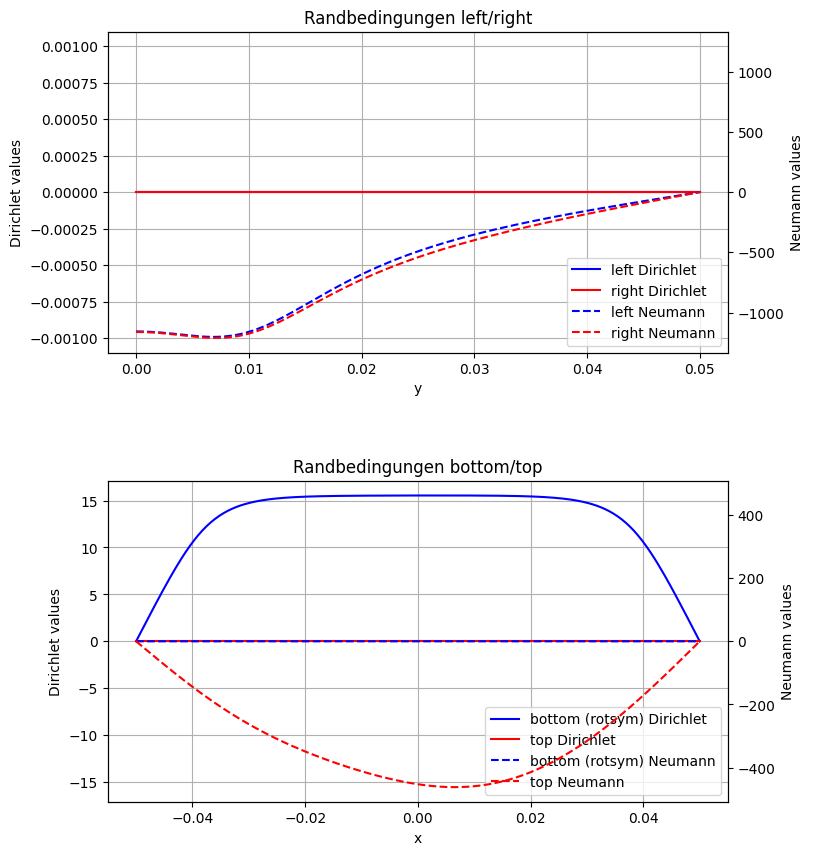

In [11]:
plotBoundaryConditions(gfT)

## Robin Randwerte

In [24]:
V2 = H1(mesh, order = 4) #, dirichlet='outer_left')
uT,vT = V2.TnT()
gfT = GridFunction(V2)

alpha = 10;
alpha_top = alpha;
alpha_right = alpha #*10;
alpha_left = alpha

aT = BilinearForm(V2)
aT += lam*grad(uT)*grad(vT)*dx
aT += lam_air*alpha_top*uT*vT*ds(definedon=mesh.Boundaries('outer_top'))
aT += lam_air*alpha_right*uT*vT*ds(definedon=mesh.Boundaries('outer_right'))
aT += lam_air*alpha_right*uT*vT*ds(definedon=mesh.Boundaries('outer_left'))

fT = LinearForm(V2)
fT += Qe*vT*dx
#fT += lam_air*(-200)*vT*ds(definedon=mesh.Boundaries('rotsym'))  # neg. is flow outside

aT.Assemble()
fT.Assemble()

gfT.vec.data = aT.mat.Inverse(V2.FreeDofs()) * fT.vec

Draw(gfT, mesh, "Temperatur")

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

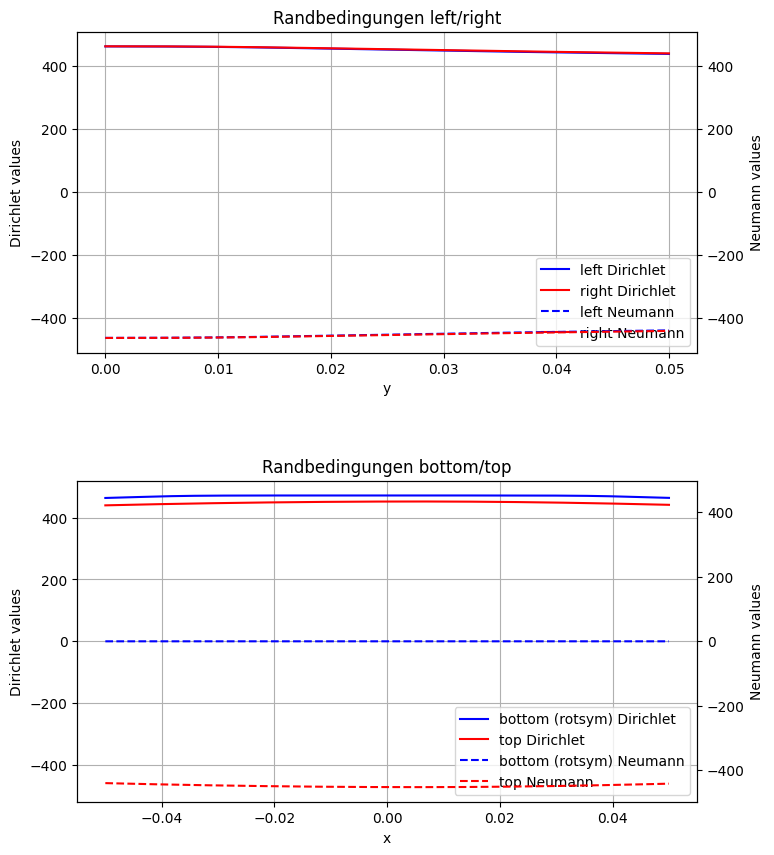

In [22]:
plotBoundaryConditions(gfT)